<center><h1>Prediction of the next word in texts using language models: <br>
    An approach based on Shakespeare's sonnets</h1></center>



**Index:**
1. Introduction
2. Text Tokenization
3. Generation of n-grams
4. Adding Padding to Sequences
5. Splitting Data into Features and Labels
6. Model Creation
7. Model Training
8. Model Evaluation
9. Text Generation
10. Conclusions

## 1. Introduction

In this work, we tackle the challenge of predicting the next word in a text sequence using language models. We implement a neural network model trained on a corpus of Shakespeare's sonnets. The goal is to create a model capable of accurately predicting the next word in a text sequence, which has applications in tasks such as automatic text generation and grammatical correction. We explore the use of techniques such as text tokenization, n-gram generation, and the use of bidirectional recurrent neural network layers to achieve this goal. Through experimentation with different model architectures and training parameters, we aim to achieve satisfactory accuracy in predicting words in a specific literary context such as Shakespeare's sonnets.

Install necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

2024-02-13 21:02:52.952843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 21:02:52.952939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 21:02:53.290576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install gdown==4.6.0

In [3]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /kaggle/working/sonnets.txt
100%|██████████████████████████████████████| 93.6k/93.6k [00:00<00:00, 91.4MB/s]


In [4]:
# Define path for file with sonnets
SONNETS_FILE = '/sonnets.txt'

# Read the data
with open('/sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## 2. Text Tokenization
In this section, we tokenize the corpus of Shakespeare's sonnets using TensorFlow's Tokenizer class. We show how text is converted into sequences of tokens and calculate the total number of words in the vocabulary.

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [6]:
corpus[0]

'from fairest creatures we desire increase,'

## 3. Generation of n-grams
Here, we implement the generation of n-grams from the tokenized corpus. We explain the process of creating n-gram sequences to feed into the next word prediction model.

In [7]:
# GRADED FUNCTION: n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary

    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    # Initialize the sequences list
    input_sequences = []

  # Loop over every line
    for line in corpus:
      # Tokenize the current line
      token_list = tokenizer.texts_to_sequences([line])[0]

      # Loop over the line several times to generate the subphrases
      for i in range(1, len(token_list)):
        # Generate the subphrase
        n_gram_sequence = token_list[:i+1]

        # Append the subphrase to the sequences list
        input_sequences.append(n_gram_sequence)

    return input_sequences

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [8]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11



## 4. Adding Padding to Sequences
The process of adding padding to n-gram sequences to make them of equal length is detailed here. We demonstrate how this step is performed using TensorFlow's pad_sequences function.

In [9]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    # Get the length of the longest line
    maxlen= max([len(x) for x in input_sequences])

    # padd all sequences
    padded_sequences = pad_sequences(input_sequences, maxlen = maxlen)

    return padded_sequences

In [10]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## 5. Splitting Data into Features and Labels

In this section, we separate the features (input_sequences) from the labels (labels) for model training. We explain how these divisions are made and use one-hot encoding for the labels.

Before feeding the data into the neural network we should split it into features and labels. In this case the features will be the padded *n_gram* sequences with the last word removed from them and the labels will be the removed word.

In [11]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [12]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## 6. Model Creation 

Now our goal is to define a model architecture capable of achieving an accuracy of at least 80%.

In [13]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model

    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()

    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(tf.keras.layers.GRU(64))),
    model.add(Dense(total_words*6, activation='relu'))
    model.add(Dense(total_words, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', #categorical_crossentropy
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

This model is a text generator that utilizes a recurrent neural network (RNN) architecture to predict the next word in a text sequence. Here's a brief summary of its structure:

1. **Embedding Layer:**
   - An embedding layer is used to represent words as dense vectors.
   - The output dimension of this layer is set to 100.
   - The input sequence length is set to `max_sequence_len - 1`.

2. **Bidirectional GRU Layer:**
   - A bidirectional layer of Gated Recurrent Units (GRU) is added to capture both past and future information of the input sequence.
   - The GRU layer has 64 units.

3. **Dense Layers:**
   - A dense layer with ReLU (Rectified Linear Unit) activation is added to increase the complexity and representation capacity of the model.
   - The output dimension of this layer is `total_words * 6`.
   - A final dense layer with softmax activation is added to produce the probability distribution over the vocabulary, which is used to predict the next word in the sequence.

4. **Model Compilation:**
   - The model is compiled using the categorical cross-entropy loss function.
   - Adam optimizer is used with a learning rate of 0.001.
   - The evaluation metric during training is accuracy.

## 7. Model Training

Model training is carried out in this section using the data prepared in the previous sections. The process of model fitting is shown, and training curves are visualized to evaluate performance.

In [14]:
import time

start_time = time.time()
model = create_model(total_words, max_sequence_len)
history = model.fit(features, labels, epochs=50, verbose=1)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")


Epoch 1/50


I0000 00:00:1707858215.330539     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


484/484 [==============================] - 24s 39ms/step - loss: 6.7568 - accuracy: 0.0281
Epoch 2/50
484/484 [==============================] - 12s 25ms/step - loss: 6.2331 - accuracy: 0.0528
Epoch 3/50
484/484 [==============================] - 12s 25ms/step - loss: 5.6745 - accuracy: 0.0739
Epoch 4/50
484/484 [==============================] - 12s 25ms/step - loss: 5.0710 - accuracy: 0.1005
Epoch 5/50
484/484 [==============================] - 12s 25ms/step - loss: 4.4245 - accuracy: 0.1431
Epoch 6/50
484/484 [==============================] - 12s 25ms/step - loss: 3.6625 - accuracy: 0.2120
Epoch 7/50
484/484 [==============================] - 12s 24ms/step - loss: 2.8446 - accuracy: 0.3423
Epoch 8/50
484/484 [==============================] - 12s 25ms/step - loss: 2.1011 - accuracy: 0.4975
Epoch 9/50
484/484 [==============================] - 12s 24ms/step - loss: 1.5759 - accuracy: 0.6101
Epoch 10/50
484/484 [==============================] - 12s 24ms/step - loss: 1.1988 - accurac

## 8. Model Evaluation

Final Accuracy: 84.92432832717896


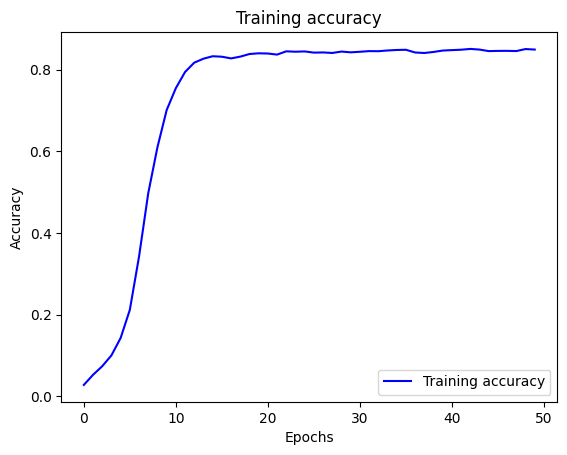

Final Loss: 49.010586738586426


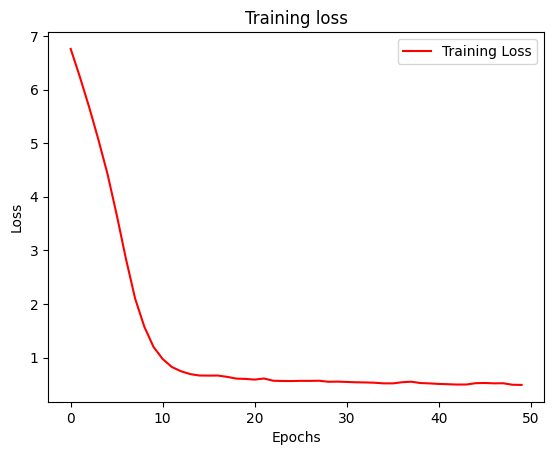

In [20]:
accuracy = history.history['accuracy']
loss = history.history['loss']

print(f"Final Accuracy: {accuracy[-1]*100}")

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"Final Loss: {loss[-1]*100}")
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



## 9. Text Generation
Text is generated using the trained model in this section. An example of how the model can generate a sequence of words from a given initial text is provided.

In [19]:
seed_text = " I love you, forever. You hear me? I love you forever. And I'm coming back. I'm coming back."
next_words = 100

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

 I love you, forever. You hear me? I love you forever. And I'm coming back. I'm coming back. the thee back of me thee and thee i speed that thee me me i thee thee thy granting ' thee my muse muse thee my my love excuse ' my my love ' my love ' me i love that in me it is see thee my heart ' my heart thy ' have done thee me heart of that me and thee i bold ' my heart me be ' of thee i see crave cheer ' to my heart be ' of my heart ' have erred seeking that smother of me to crave long now thine


## 10. Conclusions


1. **Model Performance:**
   - **Final Accuracy:** The model achieved a final accuracy of 84.92%, indicating that it has learned patterns well in the training data and can generalize effectively to new data.
   - **Final Loss:** The final loss was 49.01, suggesting that the model has significantly reduced its error during training.

2. **Generated Text:**
   - The generated text appears to have coherence in terms of grammar and vocabulary, indicating that the model has captured some linguistic structures.
   - However, there are parts of the text that seem less coherent or less semantically relevant, suggesting that the model could improve in understanding context and coherence of the generated text.
   - Some phrases have poetic or literary sense, while others may be more difficult to interpret or lack coherence.

3. **Conclusions:**
   - The model demonstrates good performance in terms of final accuracy and loss, indicating that it has learned patterns well in the training data.
   - Although the generated text has some coherence, there is still room for improvement in terms of quality and coherence of the generated text.
   - It might be worth trying different hyperparameters of the model or using more advanced techniques to further improve the quality of the generated text.

In summary, the model shows good performance in terms of evaluation metrics, but there is still room to enhance the quality of the generated text.